# Evaluación

In [1]:
!pwd
!ls
%cd meleros/notebooks/
!pwd
!ls

/home/jovyan
environment.yml  meleros  work
/home/jovyan/meleros/notebooks
/home/jovyan/meleros/notebooks
1-eda-analisis-exploratorio.ipynb
2-rn_entrenamiento.ipynb
2-rnr_entrenamiento.ipynb
3-rn_evaluacion.ipynb
3-rnr_evaluacion.ipynb
dev
estudio3_1seg_hembra_labels_mapping.json
estudio3_1seg_labels_mapping.json
estudio3_1seg_macho_labels_mapping.json
history_estudio3_1seg_hembra_topology1.json
history_estudio3_1seg_hembra_topology2.json
history_estudio3_1seg_hembra_topology3.json
history_estudio3_1seg_macho_topology1.json
history_estudio3_1seg_macho_topology2.json
history_estudio3_1seg_macho_topology3.json
history_estudio3_1seg_topology1.json
history_estudio3_1seg_topology2.json
history_estudio3_1seg_topology3.json
model_estudio3_1seg_hembra_topology1.h5
model_estudio3_1seg_hembra_topology2.h5
model_estudio3_1seg_hembra_topology3.h5
model_estudio3_1seg_macho_topology1.h5
model_estudio3_1seg_macho_topology2.h5
model_estudio3_1seg_macho_topology3.h5
model_estudio3_1seg_topology1.h5
mod

## Dataset completo

In [2]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
import json


import matplotlib.pyplot as plt

# Load h5 models for topology 1, 2 and 3
model_estudio3_1seg_topology1 = tf.keras.models.load_model('model_estudio3_1seg_topology1.h5')
model_estudio3_1seg_topology2 = tf.keras.models.load_model('model_estudio3_1seg_topology2.h5')
model_estudio3_1seg_topology3 = tf.keras.models.load_model('model_estudio3_1seg_topology3.h5')

# Load validation dataset
estudio3_1seg_val = pd.read_csv('../data/2-procesada/estudio3_normalizado_1seg_val.csv')

# Asign comportamiento result to the results dataframe
resultados = pd.DataFrame()
resultados['Comportamiento'] = estudio3_1seg_val['Comportamiento']

# Use the models to predict the validation dataset
X_val = estudio3_1seg_val.drop(columns=['Comportamiento', 'Sexo'])
y_val = pd.get_dummies(estudio3_1seg_val['Comportamiento'])
labels_mapping = y_val.columns.tolist()  # Save the mapping
X_val_scaled = StandardScaler().fit_transform(X_val)

# Compare trained label mappings with current mapping
with open('estudio3_1seg_labels_mapping.json', 'r') as f:
    train_labels_mapping = json.load(f)
    assert train_labels_mapping == labels_mapping

resultados['Topology1'] = model_estudio3_1seg_topology1.predict(X_val_scaled).argmax(axis=1)
resultados['Topology2'] = model_estudio3_1seg_topology2.predict(X_val_scaled).argmax(axis=1)
resultados['Topology3'] = model_estudio3_1seg_topology3.predict(X_val_scaled).argmax(axis=1)

# Convert predictions results to the original labels
def indices_to_labels(indices, mapping):
    return [mapping[i] for i in indices]

# Convert predictions to labels
resultados['Topology1_Labels'] = indices_to_labels(resultados['Topology1'], labels_mapping)
resultados['Topology2_Labels'] = indices_to_labels(resultados['Topology2'], labels_mapping)
resultados['Topology3_Labels'] = indices_to_labels(resultados['Topology3'], labels_mapping)

# Save the results to a csv file
resultados.to_csv('resultados_modelos_estudio3.csv', index=False)

2024-07-05 05:08:39.592815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


219/219 [==============================] - 0s 1ms/step


In [3]:
from tensorflow.keras.utils import plot_model

# Save the model structure.

# Plot the model structure
plot_model(model_estudio3_1seg_topology1, to_file='model_structure.png', show_shapes=True)
plot_model(model_estudio3_1seg_topology2, to_file='model_structure2.png', show_shapes=True)
plot_model(model_estudio3_1seg_topology3, to_file='model_structure3.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [4]:
# Calculate accuracy for Topology1_Labels
accuracy1 = (resultados['Comportamiento'] == resultados['Topology1_Labels']).mean()

# Calculate accuracy for Topology2_Labels
accuracy2 = (resultados['Comportamiento'] == resultados['Topology2_Labels']).mean()

# Calculate accuracy for Topology3_Labels
accuracy3 = (resultados['Comportamiento'] == resultados['Topology3_Labels']).mean()

# Print the accuracies
print("Accuracy for Topology1_Labels:", accuracy1)
print("Accuracy for Topology2_Labels:", accuracy2)
print("Accuracy for Topology3_Labels:", accuracy3)


Accuracy for Topology1_Labels: 0.8025432204600658
Accuracy for Topology2_Labels: 0.804257751107301
Accuracy for Topology3_Labels: 0.8028289755679383


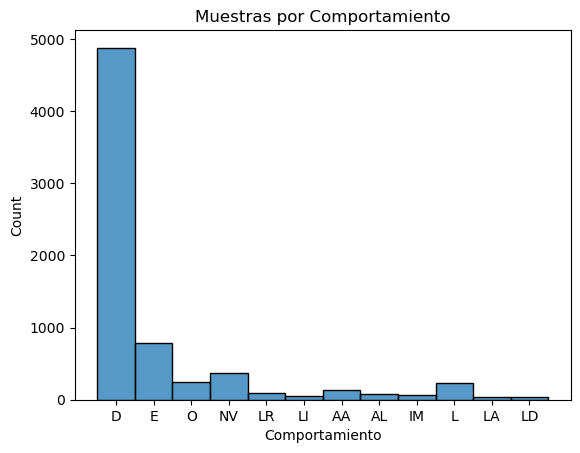

In [16]:
# Validation set sample distribution for the Comportamiento column
sns.histplot(resultados['Comportamiento'])
plt.title('Muestras por Comportamiento')
plt.show()

In [33]:
from sklearn.metrics import accuracy_score
# Class labels
class_labels = ['D', 'E', 'AL', 'O', 'IM', 'AA', 'NV', 'L', 'LD', 'LA', 'LI', 'LR']

# Function to calculate accuracy per class
def accuracy_per_class(y_true, y_pred):
    accuracies = {}
    for label in class_labels:
        mask = y_true == label
        accuracies[label] = accuracy_score(y_true[mask], y_pred[mask])
    return accuracies

topology1_acc = accuracy_per_class(resultados['Comportamiento'], resultados['Topology1_Labels'])
topology2_acc = accuracy_per_class(resultados['Comportamiento'], resultados['Topology2_Labels'])
topology3_acc = accuracy_per_class(resultados['Comportamiento'], resultados['Topology3_Labels'])

resultados_acc = pd.DataFrame({
    'Clase': class_labels,
    'Topologia 1': [topology1_acc[label] for label in class_labels],
    'Topologia 2': [topology2_acc[label] for label in class_labels],
    'Topologia 3': [topology3_acc[label] for label in class_labels],
})


print(resultados_acc)

   Clase  Topologia 1  Topologia 2  Topologia 3
0      D     0.986885     0.989344     0.989139
1      E     0.675573     0.725191     0.699746
2     AL     0.075949     0.012658     0.000000
3      O     0.020833     0.016667     0.008333
4     IM     0.048387     0.032258     0.000000
5     AA     0.046875     0.062500     0.023438
6     NV     0.100817     0.019074     0.000000
7      L     0.411255     0.380952     0.463203
8     LD     0.315789     0.342105     0.368421
9     LA     0.400000     0.000000     0.000000
10    LI     0.722222     0.870370     0.888889
11    LR     0.535354     0.616162     0.686869


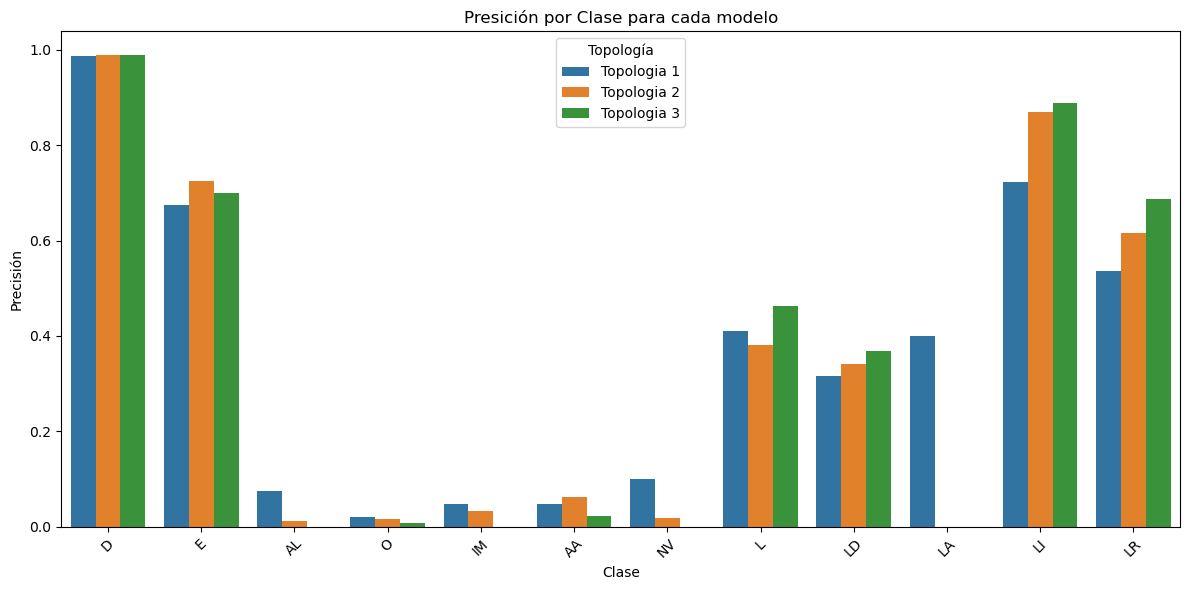

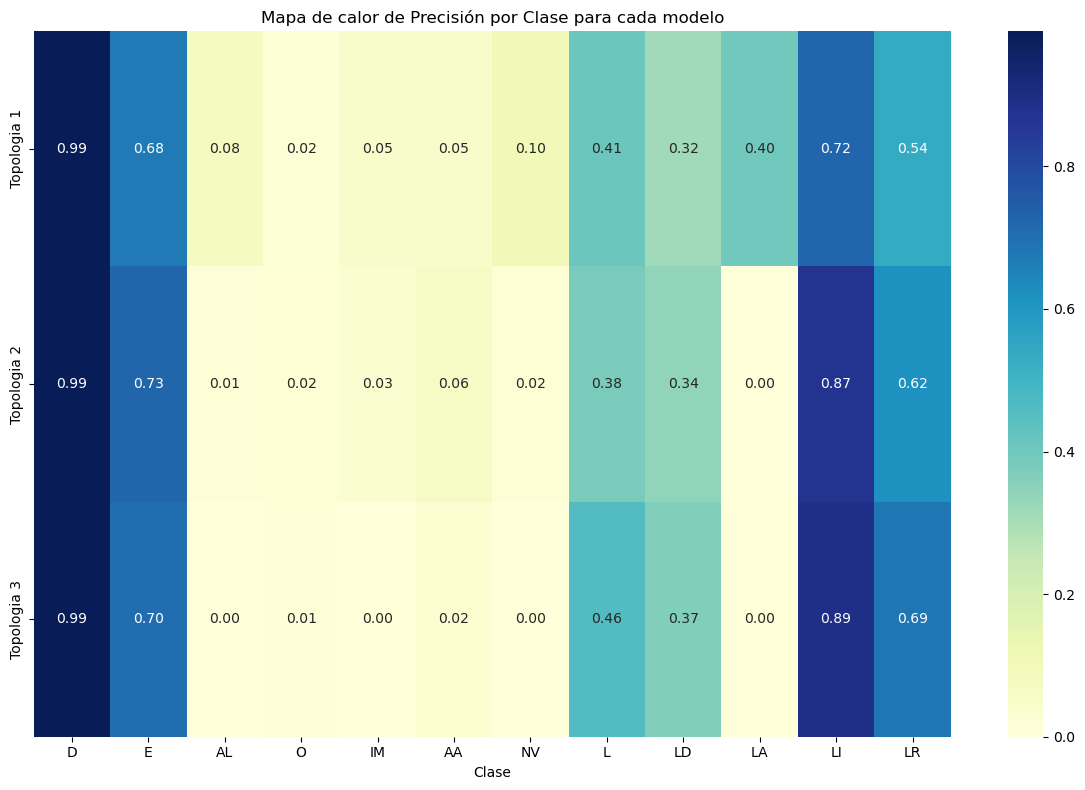

In [34]:
# melt for visualization
resultados_acc_melt = resultados_acc.melt(id_vars='Clase', var_name='Topologia', value_name='Accuracy')

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Clase', y='Accuracy', hue='Topologia', data=resultados_acc_melt)
plt.title('Presición por Clase para cada modelo')
plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.xticks(rotation=45)
plt.legend(title='Topología')
plt.tight_layout()
plt.show()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(resultados_acc.set_index('Clase').T, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Mapa de calor de Precisión por Clase para cada modelo')
plt.tight_layout()
plt.show()

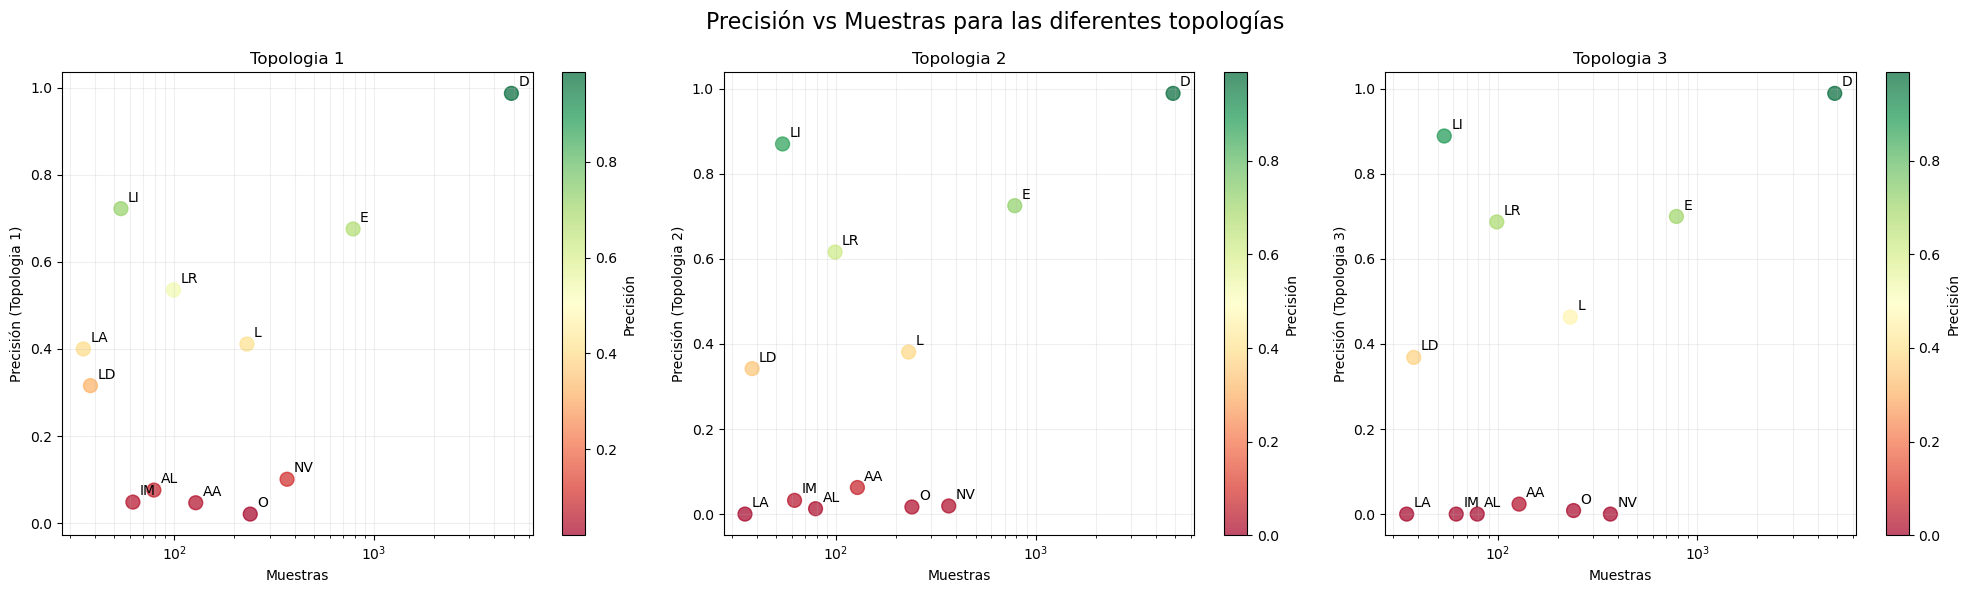

In [35]:
# Add sample count to the results dataframe
resultados_acc['Sample Count'] = resultados['Comportamiento'].value_counts()[class_labels].values


# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Precisión vs Muestras para las diferentes topologías', fontsize=16)

# Define a color map
cmap = plt.cm.RdYlGn  # Red-Yellow-Green colormap

for i, topology in enumerate(['Topologia 1', 'Topologia 2', 'Topologia 3']):
    ax = axes[i]
    scatter = ax.scatter(resultados_acc['Sample Count'], resultados_acc[topology], 
                        c=resultados_acc[topology], cmap=cmap, 
                        s=100, alpha=0.7)
    
    # Add labels for each point
    for j, txt in enumerate(resultados_acc['Clase']):
        ax.annotate(txt, (resultados_acc['Sample Count'].iloc[j], resultados_acc[topology].iloc[j]), 
                    xytext=(5, 5), textcoords='offset points')
    
    ax.set_xlabel('Muestras')
    ax.set_ylabel(f'Precisión ({topology})')
    ax.set_title(f'{topology}')
    ax.set_xscale('log')  # Use log scale for x-axis due to large range
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Precisión')

    # Improve readability
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
plt.tight_layout()
plt.show()


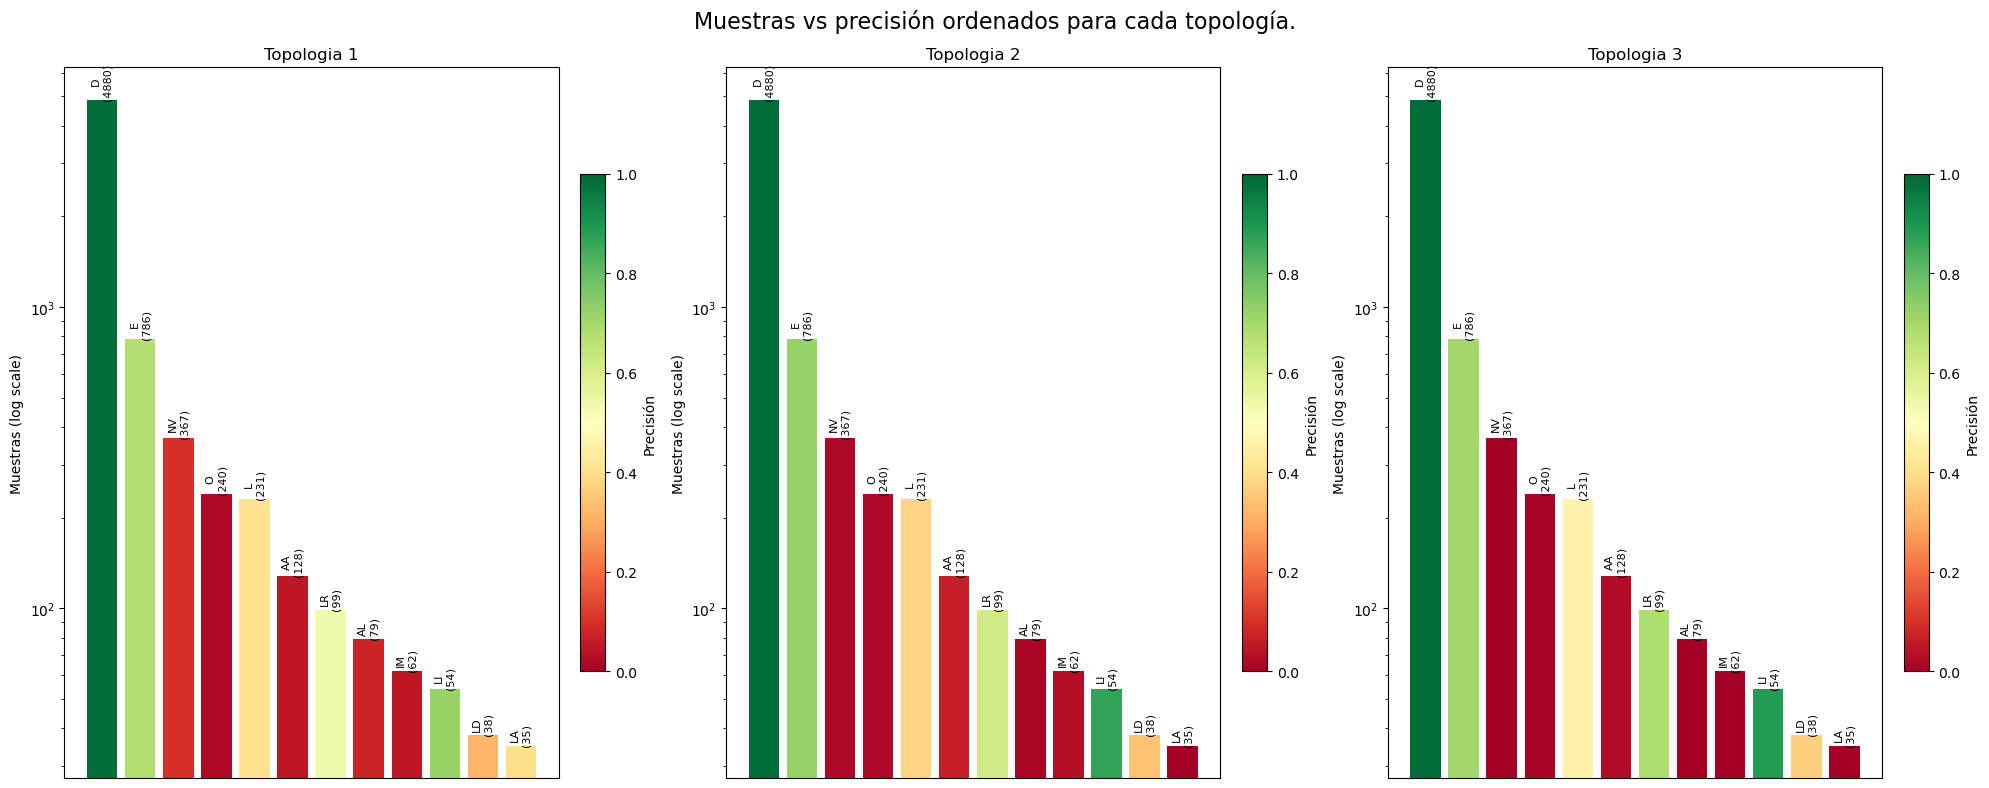

   Clase  Topologia 1  Topologia 2  Topologia 3  Sample Count
0      D     0.986885     0.989344     0.989139          4880
1      E     0.675573     0.725191     0.699746           786
6     NV     0.100817     0.019074     0.000000           367
3      O     0.020833     0.016667     0.008333           240
7      L     0.411255     0.380952     0.463203           231
5     AA     0.046875     0.062500     0.023438           128
11    LR     0.535354     0.616162     0.686869            99
2     AL     0.075949     0.012658     0.000000            79
4     IM     0.048387     0.032258     0.000000            62
10    LI     0.722222     0.870370     0.888889            54
8     LD     0.315789     0.342105     0.368421            38
9     LA     0.400000     0.000000     0.000000            35


In [36]:

# Sort the dataframe by Sample Count in descending order
resultados_acc = resultados_acc.sort_values('Sample Count', ascending=False)

# Create a figure with subplots for each topology
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('Muestras vs precisión ordenados para cada topología.', fontsize=16)

# Color map for accuracy
cmap = plt.cm.RdYlGn

for i, topology in enumerate(['Topologia 1', 'Topologia 2', 'Topologia 3']):
    ax = axes[i]
    
    # Create bar plot
    bars = ax.bar(range(len(resultados_acc)), resultados_acc['Sample Count'], 
                  color=cmap(resultados_acc[topology]))
    
    # Add labels for each bar
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f"{resultados_acc['Clase'].iloc[j]}\n({height})",
                ha='center', va='bottom', rotation=90, fontsize=8)
    
    # Remove x-axis labels and ticks
    ax.set_xticks([])
    ax.set_xticklabels([])
    
    # Set y-axis to log scale and label it
    ax.set_yscale('log')
    ax.set_ylabel('Muestras (log scale)')
    
    # Add title
    ax.set_title(f'{topology}')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Precisión', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Print accuracy values for each class and topology
print(resultados_acc[['Clase', 'Topologia 1', 'Topologia 2', 'Topologia 3', 'Sample Count']])

## Dataset machos

In [8]:
model_estudio3_1seg_macho_topology1 = tf.keras.models.load_model('model_estudio3_1seg_macho_topology1.h5')
model_estudio3_1seg_macho_topology2 = tf.keras.models.load_model('model_estudio3_1seg_macho_topology2.h5')
model_estudio3_1seg_macho_topology3 = tf.keras.models.load_model('model_estudio3_1seg_macho_topology3.h5')

# Load validation dataset
estudio3_1seg_macho_val = pd.read_csv('../data/2-procesada/estudio3_normalizado_1seg_macho_val.csv')

# Asign comportamiento result to the results dataframe
resultados_macho = pd.DataFrame()
resultados_macho['Comportamiento'] = estudio3_1seg_macho_val['Comportamiento']

# Use the models to predict the validation dataset
X_val_macho = estudio3_1seg_macho_val.drop(columns=['Comportamiento', 'Sexo'])
y_val_macho = pd.get_dummies(estudio3_1seg_macho_val['Comportamiento'])
labels_mapping = y_val_macho.columns.tolist()  # Save the mapping
X_val_macho_scaled = StandardScaler().fit_transform(X_val_macho)

# Compare trained label mappings with current mapping
with open('estudio3_1seg_macho_labels_mapping.json', 'r') as f:
    train_labels_mapping = json.load(f)
    assert train_labels_mapping == labels_mapping

resultados_macho['Topology1'] = model_estudio3_1seg_macho_topology1.predict(X_val_macho_scaled).argmax(axis=1)
resultados_macho['Topology2'] = model_estudio3_1seg_macho_topology2.predict(X_val_macho_scaled).argmax(axis=1)
resultados_macho['Topology3'] = model_estudio3_1seg_macho_topology3.predict(X_val_macho_scaled).argmax(axis=1)

# Convert predictions results to the original labels
def indices_to_labels(indices, mapping):
    return [mapping[i] for i in indices]

# Convert predictions to labels
resultados_macho['Topology1_Labels'] = indices_to_labels(resultados_macho['Topology1'], labels_mapping)
resultados_macho['Topology2_Labels'] = indices_to_labels(resultados_macho['Topology2'], labels_mapping)
resultados_macho['Topology3_Labels'] = indices_to_labels(resultados_macho['Topology3'], labels_mapping)

# Save the results to a csv file
resultados_macho.to_csv('resultados_modelos_estudio3_macho.csv', index=False)


110/110 [==============================] - 0s 2ms/step


In [9]:
# Calculate accuracy for Topology1_Labels
accuracy1_macho = (resultados_macho['Comportamiento'] == resultados_macho['Topology1_Labels']).mean()

# Calculate accuracy for Topology2_Labels
accuracy2_macho = (resultados_macho['Comportamiento'] == resultados_macho['Topology2_Labels']).mean()

# Calculate accuracy for Topology3_Labels
accuracy3_macho = (resultados_macho['Comportamiento'] == resultados_macho['Topology3_Labels']).mean()

# Print the accuracies
print("Accuracy for Topology1_Labels:", accuracy1_macho)
print("Accuracy for Topology2_Labels:", accuracy2_macho)
print("Accuracy for Topology3_Labels:", accuracy3_macho)

Accuracy for Topology1_Labels: 0.798
Accuracy for Topology2_Labels: 0.8011428571428572
Accuracy for Topology3_Labels: 0.8005714285714286


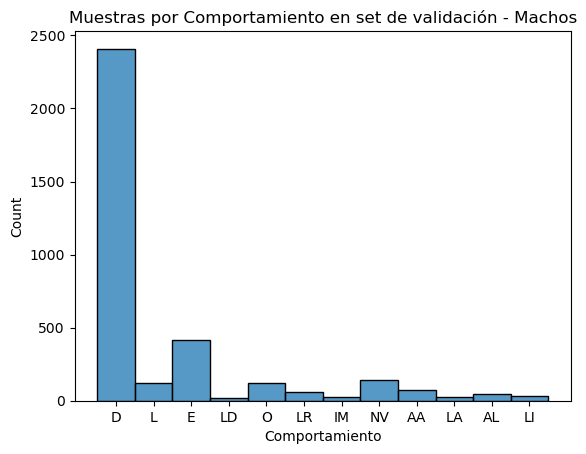

In [48]:
# Validation set sample distribution for the Comportamiento column
sns.histplot(resultados_macho['Comportamiento'])
plt.title('Muestras por Comportamiento en set de validación - Machos')
plt.show()

In [37]:
from sklearn.metrics import accuracy_score
# Class labels
class_labels = ['D', 'E', 'AL', 'O', 'IM', 'AA', 'NV', 'L', 'LD', 'LA', 'LI', 'LR']

# Function to calculate accuracy per class
def accuracy_per_class(y_true, y_pred):
    accuracies = {}
    for label in class_labels:
        mask = y_true == label
        accuracies[label] = accuracy_score(y_true[mask], y_pred[mask])
    return accuracies

topology1_acc_macho = accuracy_per_class(resultados_macho['Comportamiento'], resultados_macho['Topology1_Labels'])
topology2_acc_macho = accuracy_per_class(resultados_macho['Comportamiento'], resultados_macho['Topology2_Labels'])
topology3_acc_macho = accuracy_per_class(resultados_macho['Comportamiento'], resultados_macho['Topology3_Labels'])

resultados_acc_macho = pd.DataFrame({
    'Clase': class_labels,
    'Topologia 1': [topology1_acc_macho[label] for label in class_labels],
    'Topologia 2': [topology2_acc_macho[label] for label in class_labels],
    'Topologia 3': [topology3_acc_macho[label] for label in class_labels]
})

print(resultados_acc_macho)

   Clase  Topologia 1  Topologia 2  Topologia 3
0      D     0.984226     0.986716     0.982150
1      E     0.677033     0.703349     0.729665
2     AL     0.187500     0.208333     0.166667
3      O     0.008065     0.008065     0.008065
4     IM     0.000000     0.000000     0.000000
5     AA     0.169014     0.084507     0.126761
6     NV     0.034722     0.013889     0.034722
7      L     0.441667     0.425000     0.341667
8     LD     0.272727     0.318182     0.409091
9     LA     0.086957     0.000000     0.000000
10    LI     0.766667     0.833333     0.800000
11    LR     0.444444     0.492063     0.539683


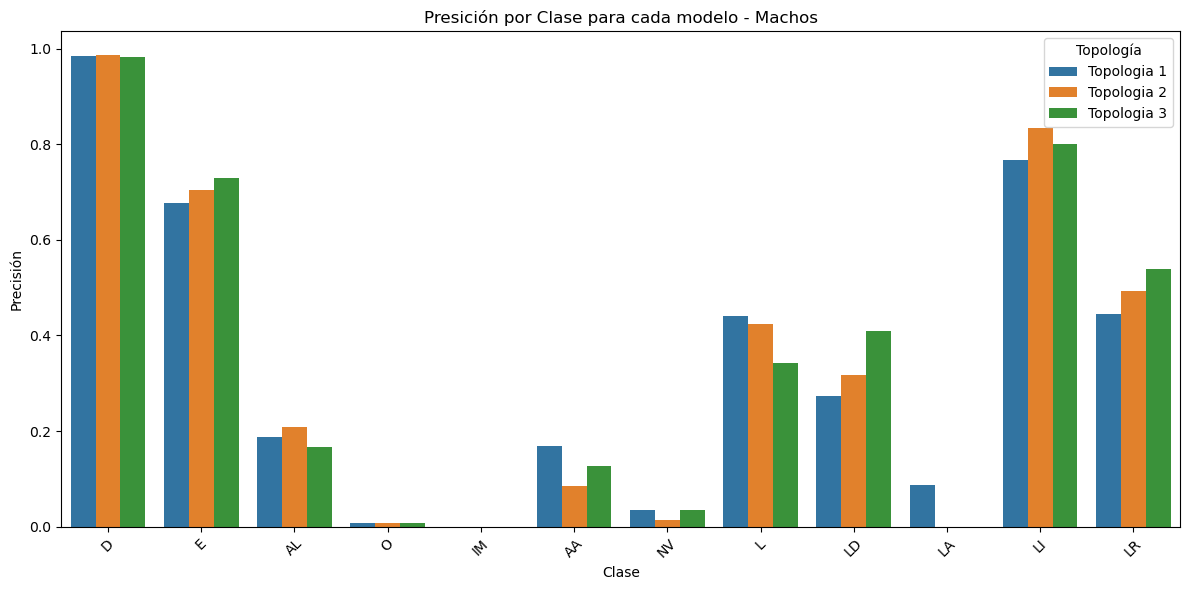

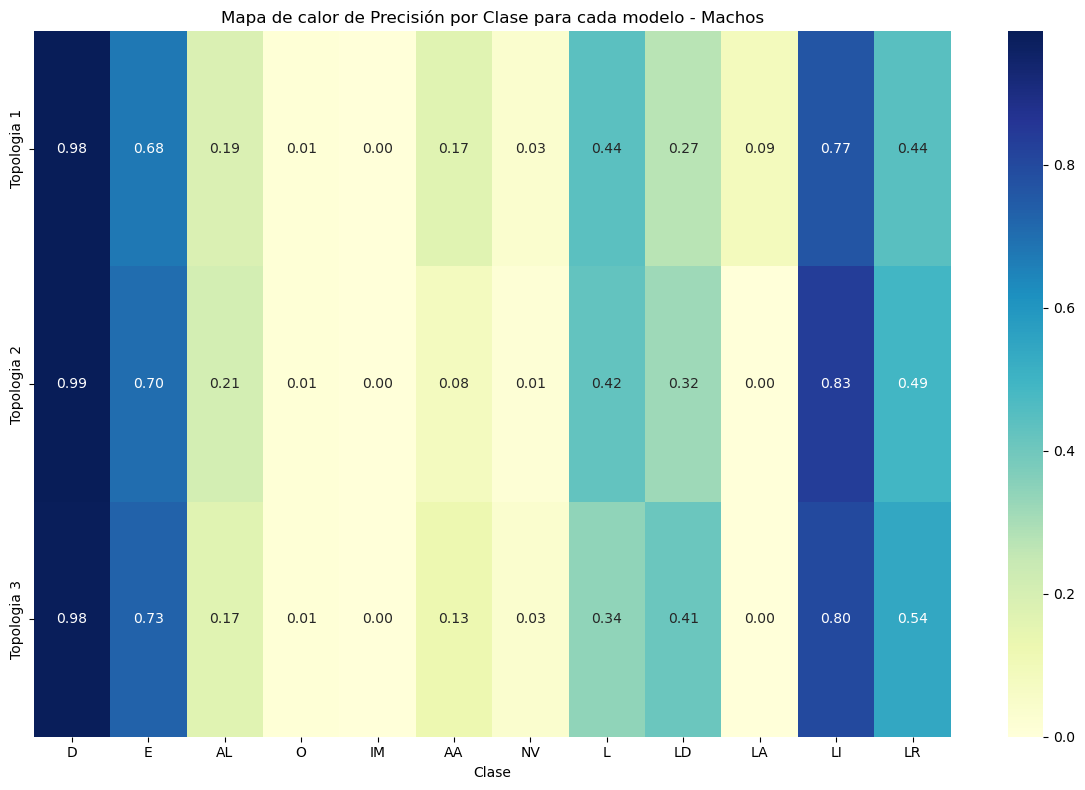

In [38]:
# melt for visualization
resultados_acc_macho_melt = resultados_acc_macho.melt(id_vars='Clase', var_name='Topologia', value_name='Accuracy')

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Clase', y='Accuracy', hue='Topologia', data=resultados_acc_macho_melt)
plt.title('Presición por Clase para cada modelo - Machos')
plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.xticks(rotation=45)
plt.legend(title='Topología')
plt.tight_layout()
plt.show()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(resultados_acc_macho.set_index('Clase').T, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Mapa de calor de Precisión por Clase para cada modelo - Machos')
plt.tight_layout()
plt.show()


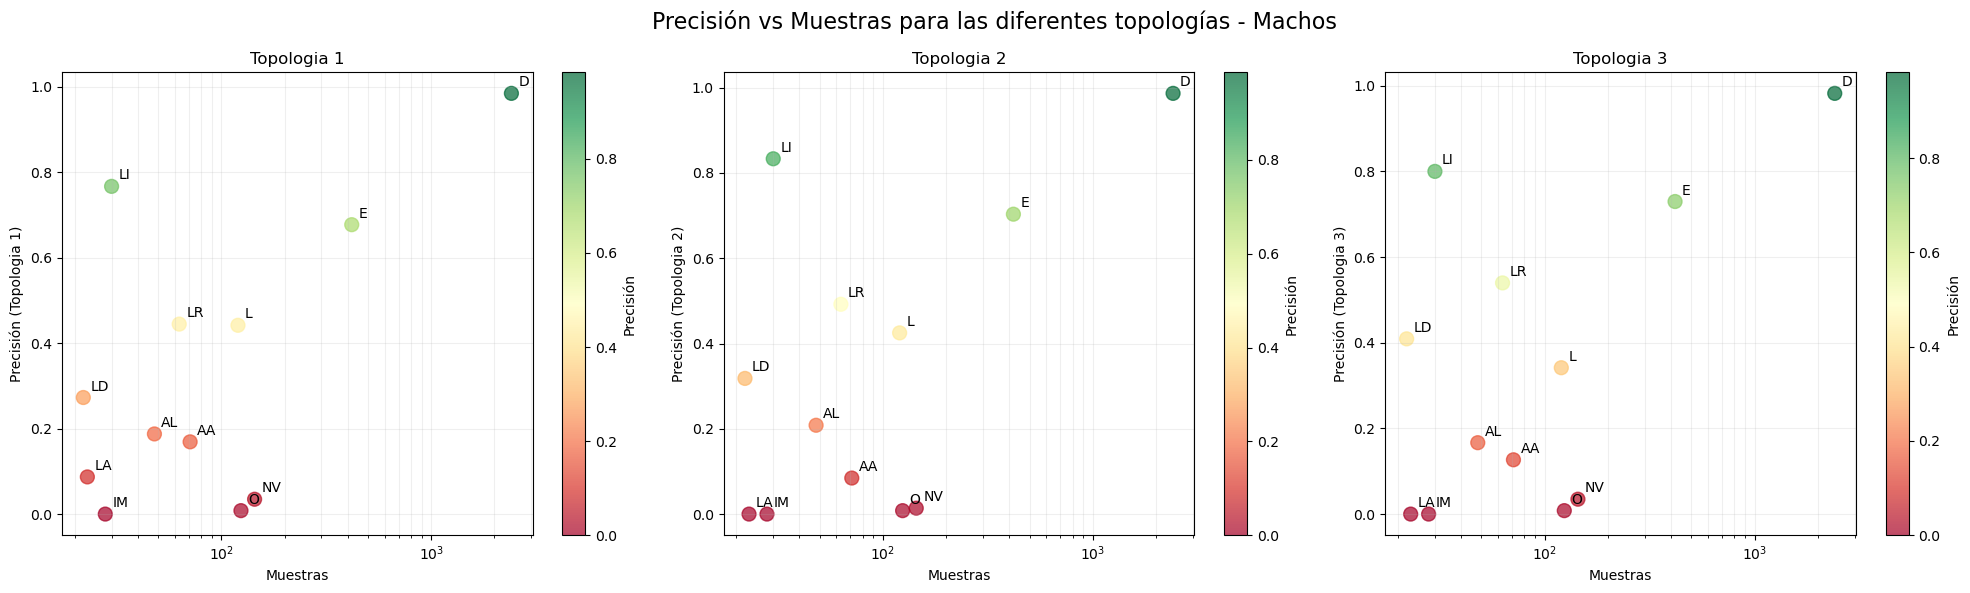

In [39]:
resultados_acc_macho['Sample Count'] = resultados_macho['Comportamiento'].value_counts()[class_labels].values

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Precisión vs Muestras para las diferentes topologías - Machos', fontsize=16)

# Define a color map
cmap = plt.cm.RdYlGn  # Red-Yellow-Green colormap

for i, topology in enumerate(['Topologia 1', 'Topologia 2', 'Topologia 3']):
    ax = axes[i]
    scatter = ax.scatter(resultados_acc_macho['Sample Count'], resultados_acc_macho[topology], 
                        c=resultados_acc_macho[topology], cmap=cmap, 
                        s=100, alpha=0.7)
    
    # Add labels for each point
    for j, txt in enumerate(resultados_acc_macho['Clase']):
        ax.annotate(txt, (resultados_acc_macho['Sample Count'].iloc[j], resultados_acc_macho[topology].iloc[j]), 
                    xytext=(5, 5), textcoords='offset points')
    
    ax.set_xlabel('Muestras')
    ax.set_ylabel(f'Precisión ({topology})')
    ax.set_title(f'{topology}')
    ax.set_xscale('log')  # Use log scale for x-axis due to large range
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Precisión')

    # Improve readability
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
plt.tight_layout()
plt.show()


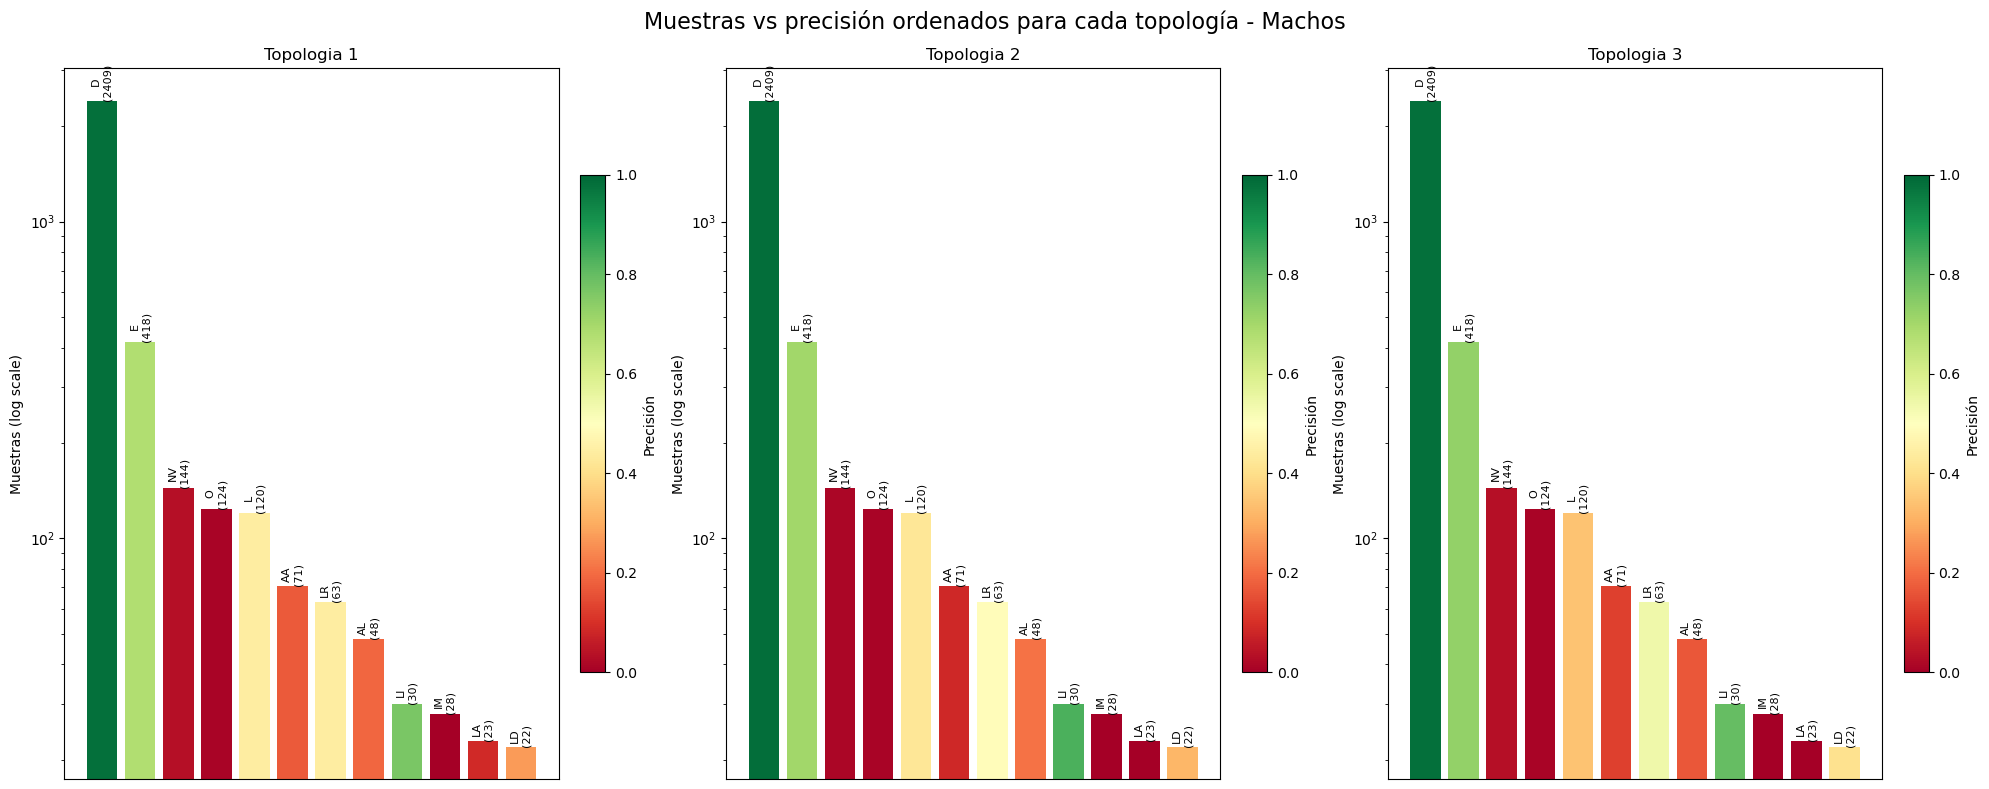

   Clase  Topologia 1  Topologia 2  Topologia 3  Sample Count
0      D     0.984226     0.986716     0.982150          2409
1      E     0.677033     0.703349     0.729665           418
6     NV     0.034722     0.013889     0.034722           144
3      O     0.008065     0.008065     0.008065           124
7      L     0.441667     0.425000     0.341667           120
5     AA     0.169014     0.084507     0.126761            71
11    LR     0.444444     0.492063     0.539683            63
2     AL     0.187500     0.208333     0.166667            48
10    LI     0.766667     0.833333     0.800000            30
4     IM     0.000000     0.000000     0.000000            28
9     LA     0.086957     0.000000     0.000000            23
8     LD     0.272727     0.318182     0.409091            22


In [40]:
# Sort the dataframe by Sample Count in descending order
resultados_acc_macho = resultados_acc_macho.sort_values('Sample Count', ascending=False)

# Create a figure with subplots for each topology
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('Muestras vs precisión ordenados para cada topología - Machos', fontsize=16)

# Color map for accuracy
cmap = plt.cm.RdYlGn

for i, topology in enumerate(['Topologia 1', 'Topologia 2', 'Topologia 3']):
    ax = axes[i]
    
    # Create bar plot
    bars = ax.bar(range(len(resultados_acc_macho)), resultados_acc_macho['Sample Count'], 
                  color=cmap(resultados_acc_macho[topology]))
    
    # Add labels for each bar
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f"{resultados_acc_macho['Clase'].iloc[j]}\n({height})",
                ha='center', va='bottom', rotation=90, fontsize=8)
    
    # Remove x-axis labels and ticks
    ax.set_xticks([])
    ax.set_xticklabels([])
    
    # Set y-axis to log scale and label it
    ax.set_yscale('log')
    ax.set_ylabel('Muestras (log scale)')
    
    # Add title
    ax.set_title(f'{topology}')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Precisión', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Print accuracy values for each class and topology
print(resultados_acc_macho[['Clase', 'Topologia 1', 'Topologia 2', 'Topologia 3', 'Sample Count']])

## Dataset hembras

In [12]:
model_estudio3_1seg_hembra_topology1 = tf.keras.models.load_model('model_estudio3_1seg_hembra_topology1.h5')
model_estudio3_1seg_hembra_topology2 = tf.keras.models.load_model('model_estudio3_1seg_hembra_topology2.h5')
model_estudio3_1seg_hembra_topology3 = tf.keras.models.load_model('model_estudio3_1seg_hembra_topology3.h5')

# Load validation dataset
estudio3_1seg_hembra_val = pd.read_csv('../data/2-procesada/estudio3_normalizado_1seg_hembra_val.csv')

# Asign comportamiento result to the results dataframe
resultados_hembra = pd.DataFrame()
resultados_hembra['Comportamiento'] = estudio3_1seg_hembra_val['Comportamiento']

# Use the models to predict the validation dataset
X_val_hembra = estudio3_1seg_hembra_val.drop(columns=['Comportamiento', 'Sexo'])
y_val_hembra = pd.get_dummies(estudio3_1seg_hembra_val['Comportamiento'])
labels_mapping = y_val_hembra.columns.tolist()  # Save the mapping
X_val_hembra_scaled = StandardScaler().fit_transform(X_val_hembra)

# Compare trained label mappings with current mapping
with open('estudio3_1seg_hembra_labels_mapping.json', 'r') as f:
    train_labels_mapping = json.load(f)
    assert train_labels_mapping == labels_mapping

resultados_hembra['Topology1'] = model_estudio3_1seg_hembra_topology1.predict(X_val_hembra_scaled).argmax(axis=1)
resultados_hembra['Topology2'] = model_estudio3_1seg_hembra_topology2.predict(X_val_hembra_scaled).argmax(axis=1)
resultados_hembra['Topology3'] = model_estudio3_1seg_hembra_topology3.predict(X_val_hembra_scaled).argmax(axis=1)

# Convert predictions results to the original labels
def indices_to_labels(indices, mapping):
    return [mapping[i] for i in indices]

# Convert predictions to labels
resultados_hembra['Topology1_Labels'] = indices_to_labels(resultados_hembra['Topology1'], labels_mapping)
resultados_hembra['Topology2_Labels'] = indices_to_labels(resultados_hembra['Topology2'], labels_mapping)
resultados_hembra['Topology3_Labels'] = indices_to_labels(resultados_hembra['Topology3'], labels_mapping)

# Save the results to a csv file
resultados_hembra.to_csv('resultados_modelos_estudio3_hembra.csv', index=False)


110/110 [==============================] - 0s 2ms/step


In [13]:
# Calculate accuracy for Topology1_Labels
accuracy1_hembra = (resultados_hembra['Comportamiento'] == resultados_hembra['Topology1_Labels']).mean()

# Calculate accuracy for Topology2_Labels
accuracy2_hembra = (resultados_hembra['Comportamiento'] == resultados_hembra['Topology2_Labels']).mean()

# Calculate accuracy for Topology3_Labels
accuracy3_hembra = (resultados_hembra['Comportamiento'] == resultados_hembra['Topology3_Labels']).mean()

# Print the accuracies
print("Accuracy for Topology1_Labels:", accuracy1_hembra)
print("Accuracy for Topology2_Labels:", accuracy2_hembra)
print("Accuracy for Topology3_Labels:", accuracy3_hembra)

Accuracy for Topology1_Labels: 0.8045714285714286
Accuracy for Topology2_Labels: 0.8011428571428572
Accuracy for Topology3_Labels: 0.7977142857142857


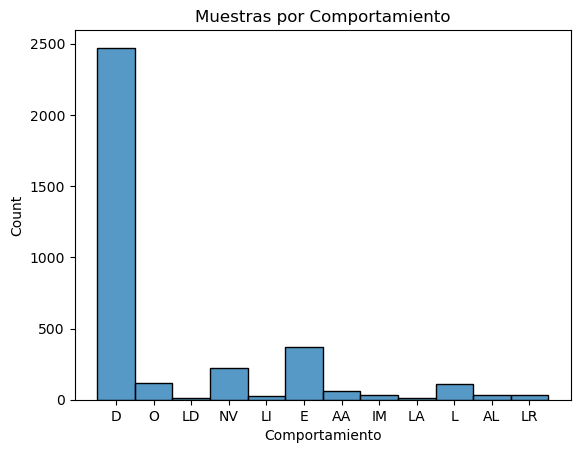

In [47]:
# Validation set sample distribution for the Comportamiento column
sns.histplot(resultados_hembra['Comportamiento'])
plt.title('Muestras por Comportamiento en set de validación - Hembras')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score
# Class labels
class_labels = ['D', 'E', 'AL', 'O', 'IM', 'AA', 'NV', 'L', 'LD', 'LA', 'LI', 'LR']

# Function to calculate accuracy per class
def accuracy_per_class(y_true, y_pred):
    accuracies = {}
    for label in class_labels:
        mask = y_true == label
        accuracies[label] = accuracy_score(y_true[mask], y_pred[mask])
    return accuracies

topology1_acc_hembra = accuracy_per_class(resultados_hembra['Comportamiento'], resultados_hembra['Topology1_Labels'])
topology2_acc_hembra = accuracy_per_class(resultados_hembra['Comportamiento'], resultados_hembra['Topology2_Labels'])
topology3_acc_hembra = accuracy_per_class(resultados_hembra['Comportamiento'], resultados_hembra['Topology3_Labels'])

resultados_acc_hembra = pd.DataFrame({
    'Clase': class_labels,
    'Topologia 1': [topology1_acc_hembra[label] for label in class_labels],
    'Topologia 2': [topology2_acc_hembra[label] for label in class_labels],
    'Topologia 3': [topology3_acc_hembra[label] for label in class_labels]
})

print(resultados_acc_hembra)

   Clase  Topologia 1  Topologia 2  Topologia 3
0      D     0.985032     0.981392     0.981796
1      E     0.554348     0.557065     0.584239
2     AL     0.225806     0.129032     0.000000
3      O     0.213675     0.059829     0.111111
4     IM     0.090909     0.000000     0.000000
5     AA     0.275862     0.137931     0.137931
6     NV     0.161435     0.237668     0.094170
7      L     0.446429     0.598214     0.553571
8     LD     0.133333     0.133333     0.333333
9     LA     0.000000     0.000000     0.000000
10    LI     0.708333     0.375000     0.916667
11    LR     0.600000     0.657143     0.542857


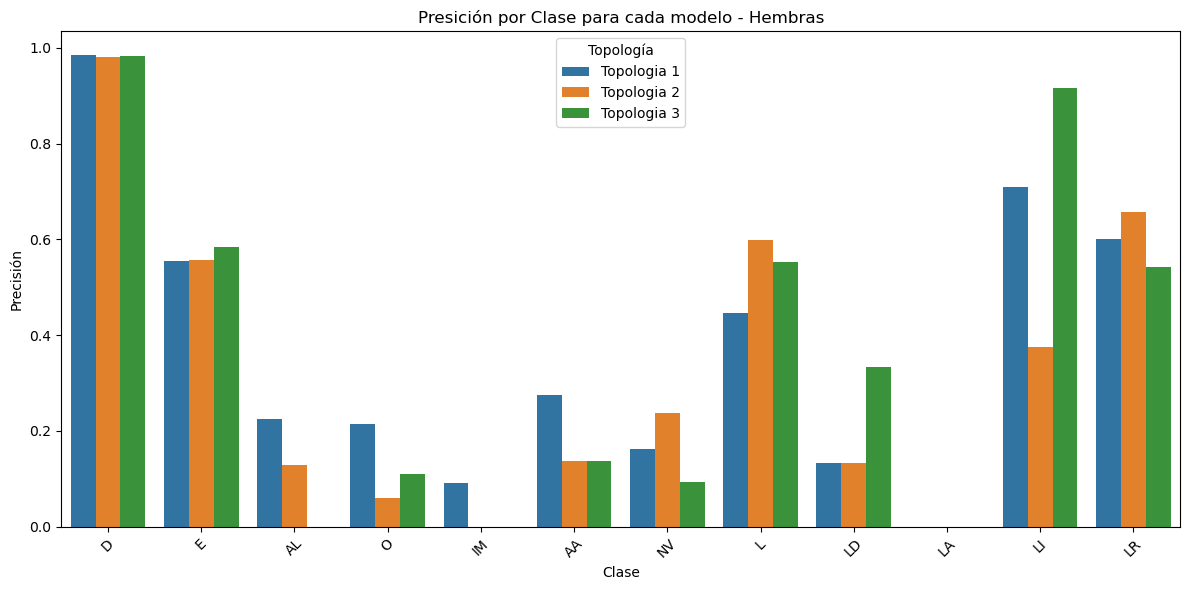

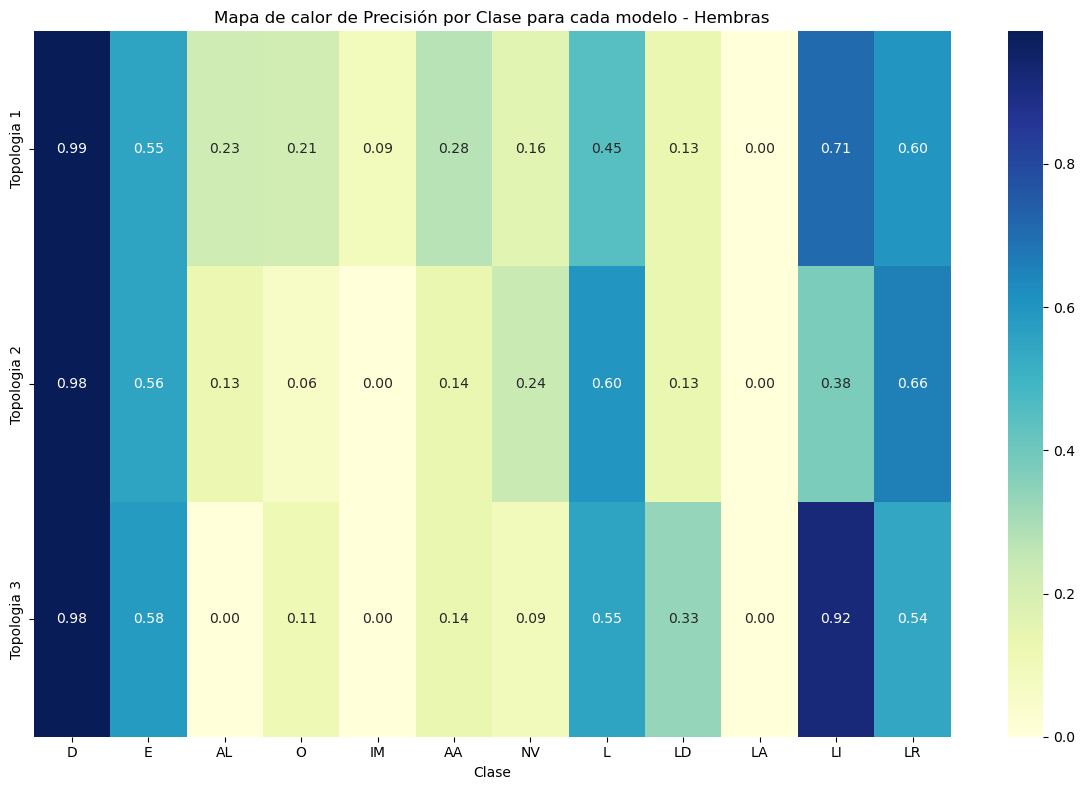

In [15]:
# melt for visualization
resultados_acc_hembra_melt = resultados_acc_hembra.melt(id_vars='Clase', var_name='Topologia', value_name='Accuracy')

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Clase', y='Accuracy', hue='Topologia', data=resultados_acc_hembra_melt)
plt.title('Presición por Clase para cada modelo - Hembras')
plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.xticks(rotation=45)
plt.legend(title='Topología')
plt.tight_layout()
plt.show()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(resultados_acc_hembra.set_index('Clase').T, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Mapa de calor de Precisión por Clase para cada modelo - Hembras')
plt.tight_layout()
plt.show()

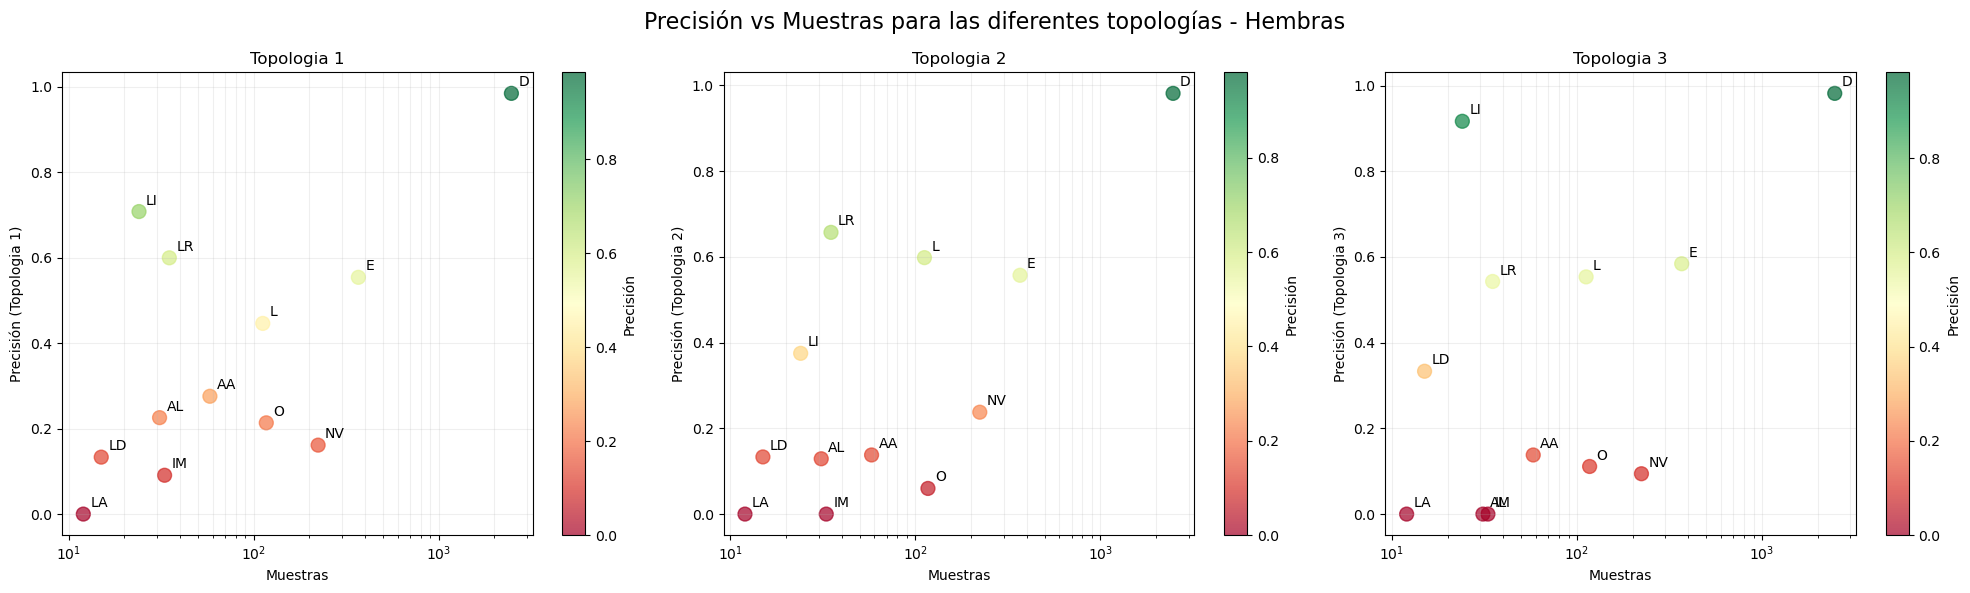

In [42]:
resultados_acc_hembra['Sample Count'] = resultados_hembra['Comportamiento'].value_counts()[class_labels].values

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Precisión vs Muestras para las diferentes topologías - Hembras', fontsize=16)

# Define a color map
cmap = plt.cm.RdYlGn  # Red-Yellow-Green colormap

for i, topology in enumerate(['Topologia 1', 'Topologia 2', 'Topologia 3']):
    ax = axes[i]
    scatter = ax.scatter(resultados_acc_hembra['Sample Count'], resultados_acc_hembra[topology], 
                        c=resultados_acc_hembra[topology], cmap=cmap, 
                        s=100, alpha=0.7)
    
    # Add labels for each point
    for j, txt in enumerate(resultados_acc_hembra['Clase']):
        ax.annotate(txt, (resultados_acc_hembra['Sample Count'].iloc[j], resultados_acc_hembra[topology].iloc[j]), 
                    xytext=(5, 5), textcoords='offset points')
    
    ax.set_xlabel('Muestras')
    ax.set_ylabel(f'Precisión ({topology})')
    ax.set_title(f'{topology}')
    ax.set_xscale('log')  # Use log scale for x-axis due to large range
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Precisión')

    # Improve readability
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
plt.tight_layout()
plt.show()


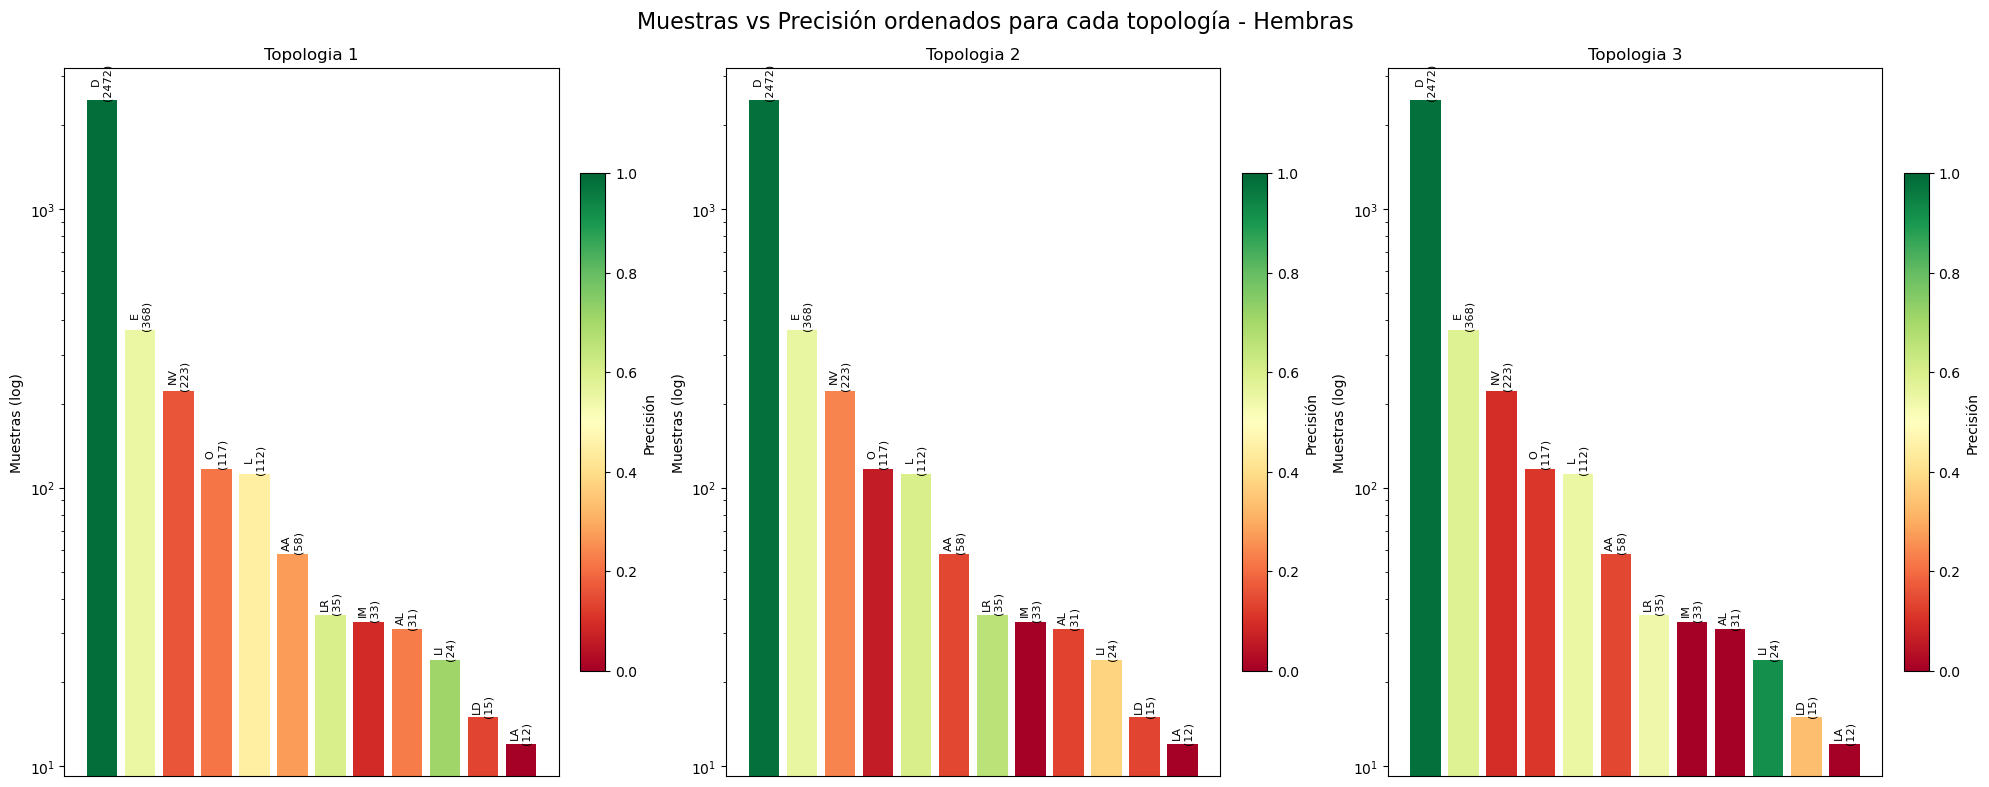

   Clase  Topologia 1  Topologia 2  Topologia 3  Sample Count
0      D     0.985032     0.981392     0.981796          2472
1      E     0.554348     0.557065     0.584239           368
6     NV     0.161435     0.237668     0.094170           223
3      O     0.213675     0.059829     0.111111           117
7      L     0.446429     0.598214     0.553571           112
5     AA     0.275862     0.137931     0.137931            58
11    LR     0.600000     0.657143     0.542857            35
4     IM     0.090909     0.000000     0.000000            33
2     AL     0.225806     0.129032     0.000000            31
10    LI     0.708333     0.375000     0.916667            24
8     LD     0.133333     0.133333     0.333333            15
9     LA     0.000000     0.000000     0.000000            12


In [45]:

# Sort the dataframe by Sample Count in descending order
resultados_acc_hembra = resultados_acc_hembra.sort_values('Sample Count', ascending=False)

# Create a figure with subplots for each topology
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('Muestras vs Precisión ordenados para cada topología - Hembras', fontsize=16)

# Color map for accuracy
cmap = plt.cm.RdYlGn

for i, topology in enumerate(['Topologia 1', 'Topologia 2', 'Topologia 3']):
    ax = axes[i]
    
    # Create bar plot
    bars = ax.bar(range(len(resultados_acc_hembra)), resultados_acc_hembra['Sample Count'], 
                  color=cmap(resultados_acc_hembra[topology]))
    
    # Add labels for each bar
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f"{resultados_acc_hembra['Clase'].iloc[j]}\n({height})",
                ha='center', va='bottom', rotation=90, fontsize=8)
    
    # Remove x-axis labels and ticks
    ax.set_xticks([])
    ax.set_xticklabels([])
    
    # Set y-axis to log scale and label it
    ax.set_yscale('log')
    ax.set_ylabel('Muestras (log)')
    
    # Add title
    ax.set_title(f'{topology}')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Precisión', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Print accuracy values for each class and topology
print(resultados_acc_hembra[['Clase', 'Topologia 1', 'Topologia 2', 'Topologia 3', 'Sample Count']])